In [82]:
import copy
import csv
import logging
import sys
import time
import warnings

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing 

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = path_to_powerflow_example + "/ieee-13-with-load-gen/"
path_to_powerflow_results = path_to_powerflow_data + "results/"

sys.path.append(path_to_powerflow_example)
from ieee13_pf import run

from change_powerflow_data import set_sample_size

In [83]:
n_original_samples = 2

if n_original_samples < 2:
    raise ValueError("n_original_samples must be an integer >1")

sample_size = 10

In [84]:
# data handling

def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return df

def collect_data(data):
    data["loads"].append(personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load"))
    data["vmags"].append(personalise_column_names(pd.read_csv(path_to_powerflow_results + "vmags.csv"), "vmag"))
    data["vangs"].append(personalise_column_names(pd.read_csv(path_to_powerflow_results + "vangs.csv"), "vang"))
    data["qmags"].append(personalise_column_names(pd.read_csv(path_to_powerflow_results + "qmags.csv"), "qmag"))
    data["linemags"].append(personalise_column_names(pd.read_csv(path_to_powerflow_results + "linemags.csv"), "linemag"))

In [85]:
data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": [], "iter": []}
data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

runs = 2
for i in range(runs):
    start_run = time.time()
#     set_sample_size(path_to_powerflow_data, data_to_change, sample_size, n_original_samples, seed=None)
#     network = run()
    collect_data(data)
    data["iter"].append(i)
    print("\n\nIteration: {} time: {}s\n\n".format(i, time.time()-start_run))



Iteration: 0 time: 0.21813368797302246s




Iteration: 1 time: 0.18992090225219727s




In [86]:
data["loads"][0].corr()

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611
load-632,1.000000,-0.003854,-0.000988,0.013969,-0.001883,0.000390,-0.001503,-0.014357,-0.011431
load-634,-0.003854,1.000000,0.016525,0.001900,-0.004175,-0.007917,0.009233,-0.003107,-0.003849
load-645,-0.000988,0.016525,1.000000,-0.009068,-0.000301,0.002463,0.011150,0.011136,-0.008043
load-646,0.013969,0.001900,-0.009068,1.000000,-0.012654,0.001012,0.007970,-0.008955,-0.005369
load-652,-0.001883,-0.004175,-0.000301,-0.012654,1.000000,0.004399,-0.003740,0.001035,0.006084
load-671,0.000390,-0.007917,0.002463,0.001012,0.004399,1.000000,0.018240,0.017143,-0.001234
load-675,-0.001503,0.009233,0.011150,0.007970,-0.003740,0.018240,1.000000,-0.004922,0.007482
load-692,-0.014357,-0.003107,0.011136,-0.008955,0.001035,0.017143,-0.004922,1.000000,-0.003015
load-611,-0.011431,-0.003849,-0.008043,-0.005369,0.006084,-0.001234,0.007482,-0.003015,1.000000


In [87]:
for idx in data["iter"]:
    print("iter: ", idx)
    features_and_targets = data["loads"][idx].join(data["vmags"][idx])
    corr_matrix = features_and_targets.corr(method="pearson")

    cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
    reduced_corr_matrix = corr_matrix[cols]
    reduced_corr_matrix = reduced_corr_matrix[~reduced_corr_matrix["load-652"].keys().str.contains("load")]

    column_avg = [np.average(reduced_corr_matrix[i].values[1:]) for i in reduced_corr_matrix] # remove nan's with [1:]

    reduced_corr_matrix.loc[len(reduced_corr_matrix)] = column_avg
    reduced_corr_matrix.rename(index={14:"column average"}, inplace=True)
    
    reduced_corr_matrix["row average"] = reduced_corr_matrix.mean(axis=1)

    display(reduced_corr_matrix)

iter:  0


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vmag-650,-0.033226,-0.135914,-0.005388,-0.026726,-0.013283,-0.157219,-0.102796,-0.019628,-0.035002,-0.058798
vmag-646,-0.095095,-0.230467,-0.165082,-0.303878,-0.057331,-0.565774,-0.417700,-0.083374,-0.087523,-0.222914
vmag-645,-0.096017,-0.235065,-0.169173,-0.234623,-0.059504,-0.577407,-0.425778,-0.085784,-0.089716,-0.219230
vmag-632,-0.097748,-0.241619,-0.079055,-0.111907,-0.063441,-0.597963,-0.439273,-0.089077,-0.094402,-0.201609
vmag-633,-0.093760,-0.350768,-0.078050,-0.108027,-0.060538,-0.574608,-0.423956,-0.085369,-0.090530,-0.207290
vmag-634,-0.050910,-0.270504,-0.037691,-0.054999,-0.024452,-0.256335,-0.195076,-0.037365,-0.049701,-0.108559
vmag-611,-0.062361,-0.158108,-0.054368,-0.074059,-0.105410,-0.697620,-0.515039,-0.105990,-0.183359,-0.217368
vmag-684,-0.063197,-0.159236,-0.055041,-0.074725,-0.105849,-0.702087,-0.518036,-0.106761,-0.146475,-0.214601
vmag-671,-0.064193,-0.160710,-0.055768,-0.075877,-0.077411,-0.707369,-0.521866,-0.107665,-0.109475,-0.208926


iter:  1


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vmag-650,-0.033226,-0.135914,-0.005388,-0.026726,-0.013283,-0.157219,-0.102796,-0.019628,-0.035002,-0.058798
vmag-646,-0.095095,-0.230467,-0.165082,-0.303878,-0.057331,-0.565774,-0.417700,-0.083374,-0.087523,-0.222914
vmag-645,-0.096017,-0.235065,-0.169173,-0.234623,-0.059504,-0.577407,-0.425778,-0.085784,-0.089716,-0.219230
vmag-632,-0.097748,-0.241619,-0.079055,-0.111907,-0.063441,-0.597963,-0.439273,-0.089077,-0.094402,-0.201609
vmag-633,-0.093760,-0.350768,-0.078050,-0.108027,-0.060538,-0.574608,-0.423956,-0.085369,-0.090530,-0.207290
vmag-634,-0.050910,-0.270504,-0.037691,-0.054999,-0.024452,-0.256335,-0.195076,-0.037365,-0.049701,-0.108559
vmag-611,-0.062361,-0.158108,-0.054368,-0.074059,-0.105410,-0.697620,-0.515039,-0.105990,-0.183359,-0.217368
vmag-684,-0.063197,-0.159236,-0.055041,-0.074725,-0.105849,-0.702087,-0.518036,-0.106761,-0.146475,-0.214601
vmag-671,-0.064193,-0.160710,-0.055768,-0.075877,-0.077411,-0.707369,-0.521866,-0.107665,-0.109475,-0.208926


Text(0.5, 0.98, 'Scatter Matrix and Histogram of Voltage and Load at Bus 671')

<Figure size 432x288 with 0 Axes>

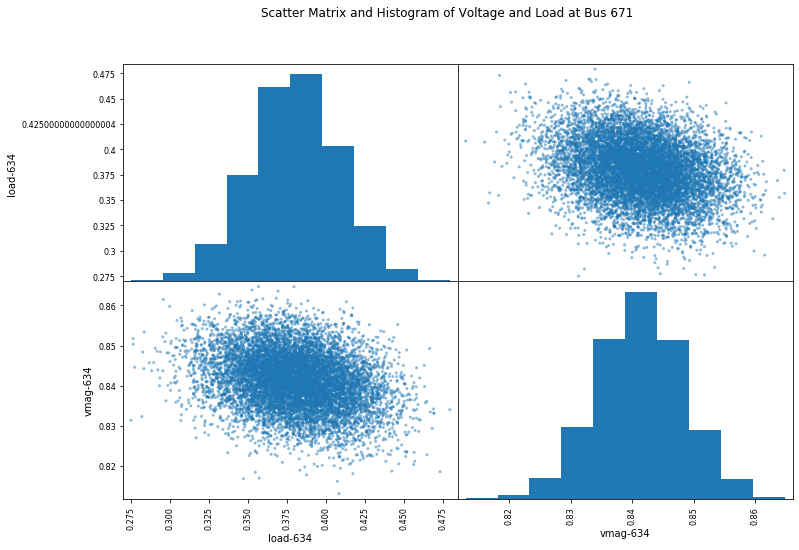

In [88]:
attributes = ["load-634", "vmag-634"]
fig = plt.figure()
ax = scatter_matrix(features_and_targets[attributes], figsize = (12, 8), diagonal='hist')
plt.suptitle("Scatter Matrix and Histogram of Voltage and Load at Bus 671")
# plt.savefig("scatter_671.pdf")

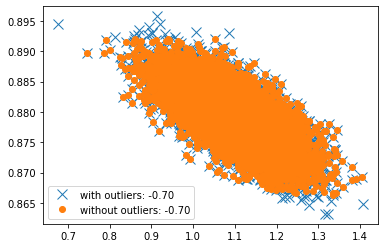

In [89]:
y = network.buses_t.v_mag_pu["671"].values
x = network.loads_t.p["671"].values
pearson_r = np.corrcoef(x, y)[0, 1]
plt.plot(x, y, 'x', markersize=10, label="with outliers: {:.5}".format(str(pearson_r)))

def reject_outliers(data, m=3, return_positions=False):
    positions = abs(data - np.mean(data)) < m * np.std(data)
    if return_positions:
        return positions
    return data[positions]

outlier_positions = reject_outliers(y, return_positions=True)
x = x[outlier_positions]
y = y[outlier_positions]

pearson_r = np.corrcoef(x, y)[0, 1]
plt.plot(x, y, 'o', label="without outliers: {:.5}".format(str(pearson_r)))
plt.legend()

## line mags

In [90]:
for idx in data["iter"]:
    print("iter: ", idx)
    features_and_targets = data["loads"][idx].join(data["linemags"][idx])
    corr_matrix = features_and_targets.corr(method="pearson")

    cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
    reduced_corr_matrix = corr_matrix[cols]
    reduced_corr_matrix = reduced_corr_matrix[~reduced_corr_matrix["load-652"].keys().str.contains("load")]

    column_avg = [np.average(reduced_corr_matrix[i].values[1:]) for i in reduced_corr_matrix] # remove nan's with [1:]

    reduced_corr_matrix.loc[len(reduced_corr_matrix)] = column_avg
    reduced_corr_matrix.rename(index={14:"column average"}, inplace=True)
    
    reduced_corr_matrix["row average"] = reduced_corr_matrix.mean(axis=1)

    display(reduced_corr_matrix)

iter:  0


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
linemag-1,0.010903,0.011958,0.588768,0.802879,-0.010351,0.003506,0.013835,-0.000479,-0.008891,0.156903
linemag-2,-0.003686,0.999970,0.016590,0.002053,-0.004152,-0.007478,0.009611,-0.003036,-0.003695,0.111797
linemag-4,0.014001,0.002002,-0.008997,0.999998,-0.012646,0.001229,0.008114,-0.008924,-0.005324,0.109939
linemag-5,0.116285,0.240876,0.112674,0.142927,0.082658,0.751305,0.562930,0.115223,0.109780,0.248295
linemag-6,-0.001862,-0.004047,-0.000193,-0.012609,0.999991,0.005045,-0.003313,0.001095,0.006248,0.110039
linemag-7,-0.002873,-0.000470,0.008898,0.003330,0.090696,0.795566,0.590924,0.124604,0.119700,0.192264
linemag-8,-0.010115,-0.005315,-0.006416,-0.011810,0.610305,0.002882,0.004501,-0.001616,0.795856,0.153141
linemag-9,0.001686,-0.000676,-0.010996,-0.003978,0.011428,-0.009500,-0.000658,0.009495,-0.011303,-0.001611
linemag-11,-0.011406,-0.003794,-0.008018,-0.005351,0.006121,-0.000987,0.007667,-0.002988,1.000000,0.109027
linemag-12,-0.001420,0.009419,0.011210,0.008042,-0.003669,0.018959,0.999998,-0.004843,0.007610,0.116145


iter:  1


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
linemag-1,0.010903,0.011958,0.588768,0.802879,-0.010351,0.003506,0.013835,-0.000479,-0.008891,0.156903
linemag-2,-0.003686,0.999970,0.016590,0.002053,-0.004152,-0.007478,0.009611,-0.003036,-0.003695,0.111797
linemag-4,0.014001,0.002002,-0.008997,0.999998,-0.012646,0.001229,0.008114,-0.008924,-0.005324,0.109939
linemag-5,0.116285,0.240876,0.112674,0.142927,0.082658,0.751305,0.562930,0.115223,0.109780,0.248295
linemag-6,-0.001862,-0.004047,-0.000193,-0.012609,0.999991,0.005045,-0.003313,0.001095,0.006248,0.110039
linemag-7,-0.002873,-0.000470,0.008898,0.003330,0.090696,0.795566,0.590924,0.124604,0.119700,0.192264
linemag-8,-0.010115,-0.005315,-0.006416,-0.011810,0.610305,0.002882,0.004501,-0.001616,0.795856,0.153141
linemag-9,0.001686,-0.000676,-0.010996,-0.003978,0.011428,-0.009500,-0.000658,0.009495,-0.011303,-0.001611
linemag-11,-0.011406,-0.003794,-0.008018,-0.005351,0.006121,-0.000987,0.007667,-0.002988,1.000000,0.109027
linemag-12,-0.001420,0.009419,0.011210,0.008042,-0.003669,0.018959,0.999998,-0.004843,0.007610,0.116145


Text(0.5, 0.98, 'Scatter Matrix and Histogram of Voltage and Load at Bus 671')

<Figure size 432x288 with 0 Axes>

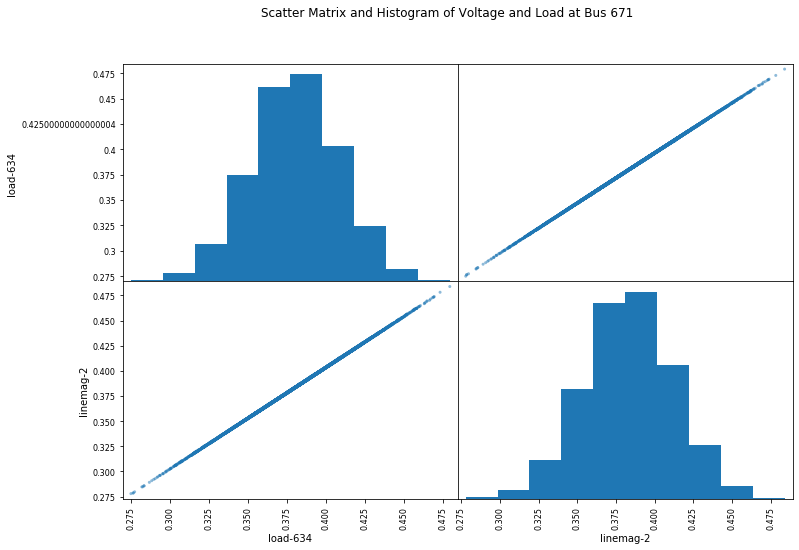

In [91]:
attributes = ["load-634", "linemag-2"]
fig = plt.figure()
ax = scatter_matrix(features_and_targets[attributes], figsize = (12, 8), diagonal='hist')
plt.suptitle("Scatter Matrix and Histogram of Voltage and Load at Bus 671")
# plt.savefig("scatter_671.pdf")

In [92]:
for idx in data["iter"]:
    print("iter: ", idx)
    features_and_targets = data["linemags"][idx].join(data["vmags"][idx])
    corr_matrix = features_and_targets.corr(method="pearson")

    cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^linemag", regex=True)[i]]
    reduced_corr_matrix = corr_matrix[cols]
    reduced_corr_matrix = reduced_corr_matrix[~reduced_corr_matrix["linemag-2"].keys().str.contains("linemag")]

    column_avg = [np.average(reduced_corr_matrix[i].values[1:]) for i in reduced_corr_matrix] # remove nan's with [1:]

    reduced_corr_matrix.loc[len(reduced_corr_matrix)] = column_avg
    reduced_corr_matrix.rename(index={14:"column average"}, inplace=True)
    
    reduced_corr_matrix["row average"] = reduced_corr_matrix.mean(axis=1)

    display(reduced_corr_matrix)

iter:  0


,linemag-1,linemag-2,linemag-4,linemag-5,linemag-6,linemag-7,linemag-8,linemag-9,linemag-11,linemag-12,linemag-13,row average
vmag-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vmag-650,-0.027750,-0.139184,-0.027251,-0.261075,-0.014185,-0.204046,-0.037092,-0.016045,-0.035188,-0.102573,-0.104530,-0.088084
vmag-646,-0.346800,-0.232764,-0.304392,-0.819872,-0.058370,-0.717354,-0.105769,-0.002268,-0.087833,-0.417992,-0.426622,-0.320003
vmag-645,-0.293287,-0.237398,-0.235139,-0.826036,-0.060561,-0.731970,-0.108849,-0.002608,-0.090030,-0.426070,-0.435022,-0.313361
vmag-632,-0.140384,-0.244011,-0.112417,-0.826141,-0.064519,-0.757316,-0.114981,-0.004277,-0.094723,-0.439559,-0.448906,-0.295203
vmag-633,-0.136616,-0.353146,-0.108532,-0.823852,-0.061593,-0.728929,-0.110123,-0.004183,-0.090846,-0.424255,-0.433159,-0.297748
vmag-634,-0.068484,-0.277468,-0.055284,-0.411613,-0.025082,-0.330702,-0.055215,-0.012536,-0.049895,-0.195346,-0.199068,-0.152790
vmag-611,-0.094708,-0.159932,-0.074503,-0.916733,-0.106455,-0.892263,-0.210832,0.000116,-0.183689,-0.515455,-0.526715,-0.334652
vmag-684,-0.095654,-0.161065,-0.075171,-0.918364,-0.106894,-0.893369,-0.181889,-0.000313,-0.146808,-0.518450,-0.529805,-0.329798
vmag-671,-0.097025,-0.162547,-0.076324,-0.918827,-0.078450,-0.893040,-0.135367,-0.000435,-0.109810,-0.522276,-0.533737,-0.320712


iter:  1


,linemag-1,linemag-2,linemag-4,linemag-5,linemag-6,linemag-7,linemag-8,linemag-9,linemag-11,linemag-12,linemag-13,row average
vmag-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vmag-650,-0.027750,-0.139184,-0.027251,-0.261075,-0.014185,-0.204046,-0.037092,-0.016045,-0.035188,-0.102573,-0.104530,-0.088084
vmag-646,-0.346800,-0.232764,-0.304392,-0.819872,-0.058370,-0.717354,-0.105769,-0.002268,-0.087833,-0.417992,-0.426622,-0.320003
vmag-645,-0.293287,-0.237398,-0.235139,-0.826036,-0.060561,-0.731970,-0.108849,-0.002608,-0.090030,-0.426070,-0.435022,-0.313361
vmag-632,-0.140384,-0.244011,-0.112417,-0.826141,-0.064519,-0.757316,-0.114981,-0.004277,-0.094723,-0.439559,-0.448906,-0.295203
vmag-633,-0.136616,-0.353146,-0.108532,-0.823852,-0.061593,-0.728929,-0.110123,-0.004183,-0.090846,-0.424255,-0.433159,-0.297748
vmag-634,-0.068484,-0.277468,-0.055284,-0.411613,-0.025082,-0.330702,-0.055215,-0.012536,-0.049895,-0.195346,-0.199068,-0.152790
vmag-611,-0.094708,-0.159932,-0.074503,-0.916733,-0.106455,-0.892263,-0.210832,0.000116,-0.183689,-0.515455,-0.526715,-0.334652
vmag-684,-0.095654,-0.161065,-0.075171,-0.918364,-0.106894,-0.893369,-0.181889,-0.000313,-0.146808,-0.518450,-0.529805,-0.329798
vmag-671,-0.097025,-0.162547,-0.076324,-0.918827,-0.078450,-0.893040,-0.135367,-0.000435,-0.109810,-0.522276,-0.533737,-0.320712


In [94]:
for idx in data["iter"]:
    print("iter: ", idx)
    features_and_targets = data["loads"][idx].join(data["vangs"][idx])
    corr_matrix = features_and_targets.corr(method="pearson")

    cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
    reduced_corr_matrix = corr_matrix[cols]
    reduced_corr_matrix = reduced_corr_matrix[~reduced_corr_matrix["load-634"].keys().str.contains("load")]

    column_avg = [np.average(reduced_corr_matrix[i].values[1:]) for i in reduced_corr_matrix] # remove nan's with [1:]

    reduced_corr_matrix.loc[len(reduced_corr_matrix)] = column_avg
    reduced_corr_matrix.rename(index={14:"column average"}, inplace=True)
    
    reduced_corr_matrix["row average"] = reduced_corr_matrix.mean(axis=1)

    display(reduced_corr_matrix)

iter:  0


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vang-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vang-650,-0.116336,-0.243614,-0.111614,-0.142411,-0.082257,-0.749185,-0.560732,-0.114697,-0.109961,-0.247868
vang-646,-0.107449,-0.198409,-0.121349,-0.157442,-0.080025,-0.709176,-0.538637,-0.111031,-0.098581,-0.235789
vang-645,-0.108072,-0.200473,-0.122772,-0.150687,-0.080465,-0.714770,-0.542428,-0.111883,-0.099742,-0.236810
vang-632,-0.109699,-0.205693,-0.114833,-0.139333,-0.081237,-0.726929,-0.549462,-0.112922,-0.102344,-0.238050
vang-633,-0.106894,-0.186542,-0.112963,-0.136496,-0.080479,-0.716818,-0.541107,-0.111472,-0.099601,-0.232486
vang-634,-0.041095,-0.927340,-0.058055,-0.056763,-0.028128,-0.280100,-0.223866,-0.041775,-0.038133,-0.188362
vang-611,-0.090620,-0.174474,-0.103361,-0.117854,-0.077390,-0.647986,-0.494834,-0.101489,-0.100823,-0.212092
vang-684,-0.090847,-0.175191,-0.103352,-0.118344,-0.077419,-0.649164,-0.495506,-0.101934,-0.095334,-0.211899
vang-671,-0.090959,-0.176210,-0.103861,-0.118856,-0.073979,-0.652430,-0.497352,-0.102453,-0.090646,-0.211861


iter:  1


,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vang-Substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vang-650,-0.116336,-0.243614,-0.111614,-0.142411,-0.082257,-0.749185,-0.560732,-0.114697,-0.109961,-0.247868
vang-646,-0.107449,-0.198409,-0.121349,-0.157442,-0.080025,-0.709176,-0.538637,-0.111031,-0.098581,-0.235789
vang-645,-0.108072,-0.200473,-0.122772,-0.150687,-0.080465,-0.714770,-0.542428,-0.111883,-0.099742,-0.236810
vang-632,-0.109699,-0.205693,-0.114833,-0.139333,-0.081237,-0.726929,-0.549462,-0.112922,-0.102344,-0.238050
vang-633,-0.106894,-0.186542,-0.112963,-0.136496,-0.080479,-0.716818,-0.541107,-0.111472,-0.099601,-0.232486
vang-634,-0.041095,-0.927340,-0.058055,-0.056763,-0.028128,-0.280100,-0.223866,-0.041775,-0.038133,-0.188362
vang-611,-0.090620,-0.174474,-0.103361,-0.117854,-0.077390,-0.647986,-0.494834,-0.101489,-0.100823,-0.212092
vang-684,-0.090847,-0.175191,-0.103352,-0.118344,-0.077419,-0.649164,-0.495506,-0.101934,-0.095334,-0.211899
vang-671,-0.090959,-0.176210,-0.103861,-0.118856,-0.073979,-0.652430,-0.497352,-0.102453,-0.090646,-0.211861
